# FIT5201 Data analysis algorithms S1 2019 
# Assignment 1
#### Student Name: Nisheeth Shah
#### Student ID: 29599644
#### Email Id: nsha0020@student.monash.edu

Date: 04/04/2019

Environment: R version 3.4.3. <br>
Libraries used:
- reshape2
- ggplot2
- MASS

# Section F. Multiclass Perceptron
### Question 8: Multiclass Perceptron

    I. Load data files
    II. Train the multiclass perceptron on the provided training data. Evaluate and plot the error.
    III. Use one-versus-one approach to solve the multi-class classification problem

### Importing libraries

In [25]:
## Load required libraries:
library(MASS) # generates multivariate Gaussian sampels
library(ggplot2)
library(reshape2)

## Initialization
set.seed(1234)

### Read train and test datasets

In [26]:
dtrain <- read.csv("Task2C_train.csv",head=TRUE,sep=",") 
dtest <- read.csv("Task2C_test.csv",head=TRUE,sep=",") 

# Separate input variables and class labels
dataAndLabels <- function(data){
    nr = dim(data)[1]
    nc = dim(data)[2]
    x = data[1:nr,1:(nc-1)]
    y = data[1:nr,nc]
    return (list("x" = x, "y" = y))
}
train.data <- dataAndLabels(dtrain)
test.data <- dataAndLabels(dtest)
head(train.data$y)

[1] C1 C1 C1 C1 C1 C1
Levels: C1 C2 C3

### Task II and III: Implementation of Multiclass Perceptron Model:

In [27]:
## Basis function
Phi <- as.matrix(cbind(1, train.data$x)) # add a column of 1s as phi_0
Phi.test <- as.matrix(cbind(1, test.data$x))

Before going further, let's set the parameters. We also need to create some empty matrices for future uses.

In [28]:
# Initialization of parameters
eta <- 0.1 # Learning rate
tau.max <- 100 # Maximum number of iterations
epsilon <- 0.001 # Stoping criterion

tau <- 1 # iteration counter 
terminate <- FALSE # termination status

Lets create weight vector for each class

In [29]:
# W is a list that stores weight vectors
W = list() 

W$C1 <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty matrix for C1 class's weight vector
W$C1[1,] <- runif(ncol(Phi)) # Random initial values for weight vector

W$C2 <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty matrix for C2 class's weight vector
W$C2[1,] <- runif(ncol(Phi)) # Random initial values for weight vector

W$C3 <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty matrix for C3 class's weight vector
W$C3[1,] <- runif(ncol(Phi)) # Random initial values for weight vector

# Create empty data frame to store test error for every mini batch
errors <- data.frame('dataPoints' = numeric(), 'miniBatch' = numeric(), 'testError' = numeric(), 'tau' = numeric())
trainingError <- data.frame()

Function to predict the class based on maximum score

In [30]:
# predict_class function predicts the classlable for a given set of input variable
pred_class <- function(Phi, tau){
    C1_score = W$C1[tau,] %*% Phi
    C2_score = W$C2[tau,] %*% Phi
    C3_score = W$C3[tau,] %*% Phi

    pred = max(C1_score, C2_score, C3_score) # make prediction based on the highest score
    
    # return the lable for the predicted class
    if(pred == C1_score)
        return ('C1')
    if(pred == C2_score)
        return ('C2')
    if(pred == C3_score)
        return ('C3')    
}

The following is the main loop where we learn the model paramters using SGD.

In [31]:
dataPoints = 1 # counter to count total number of data points processed for training the model

# Main Loop (Step 2):
while(!terminate){
    # resuffling train data and associated labels:
    train.index <- sample(1:nrow(train.data$x), replace = FALSE)
    train.data$y <- train.data$y[train.index]
    Phi <- Phi[train.index,]
    
    er_train = 0
    for (i in train.index){
        if (tau == tau.max) {break}
        
        # call predict_class function to make a prediction
        predictedClass = pred_class(Phi[i,], tau)
        trueClass = toString(train.data$y[i])

        # Check predicted class against true class and if not a true predictin, update weight for the predicted class and
        # true class
        if (predictedClass != trueClass){
            # update tau counter
            tau <- tau +1
            er_train = er_train + 1 # update training error count
            
            # update the weights. Weight for wrong prediction is decreased and weight for true class is increased to improve
            # selection criteria of model
            W[[trueClass]][tau,] = W[[trueClass]][tau-1,] + (eta * Phi[i,])
            W[[predictedClass]][tau,] = W[[predictedClass]][tau-1,] - (eta * Phi[i,])
            
            # Just update the weight vector for the remaining class with same values
            remainingClass = setdiff(c('C1', 'C2', 'C3'), c(trueClass, predictedClass)) # select the remaining class
            W[[remainingClass]][tau,] = W[[remainingClass]][tau-1,]
        }
        
        if (dataPoints %% 5 == 0){
            error = 0 # to count number of mispredictions

            for (j in 1:nrow(test.data$x)){
                
                pred = pred_class(Phi.test[j,], tau)
                if (pred != toString(test.data$y[j])){
                    error = error + 1
                }
            }
            # compute error for the current batch
            error = error / nrow(test.data$x)
            # save the data frame
            errors[nrow(errors)+1, 'dataPoints'] = dataPoints # update row value
            errors[nrow(errors), 'miniBatch'] = dataPoints/5 
            errors[nrow(errors), 'testError'] = error
            errors[nrow(errors), 'tau'] = tau          

        }
        dataPoints = dataPoints + 1
        
    }

    # decrease eta:
    eta = eta * 0.99
    
    # calculate training error
    trainingError[nrow(trainingError)+1, 1] = er_train/ length(train.index)
    
    # check termination conditions
    if (tau >= tau.max){
        terminate <- TRUE
    }
    else if (nrow(trainingError) >= 2 && trainingError[nrow(trainingError),1] < 0.03){
        # check if there is atleast two recorded training errors and training error is less than 3%
        improvement = trainingError[nrow(trainingError),1] - trainingError[nrow(trainingError)-1, 1]
        terminate = improvement < epsilon # terminate if the improvement is minimal
        }
}

W$C1 <- W$C1[1:tau,] # cut the empty part of the matrix (when the loop stops before tau == tau.max)
W$C2 <- W$C2[1:tau,]
W$C3 <- W$C3[1:tau,]

Done! Let's print the learnt weight vector.

In [32]:
## report
cat('\n\nThe  final weight vector for C1:', W$C1[tau,])
cat('\n\nThe  final weight vector for C2:', W$C2[tau,])
cat('\n\nThe  final weight vector for C3:', W$C3[tau,])



The  final weight vector for C1: 0.4127034 1.121988 2.368693 -1.581865 -0.1925016

The  final weight vector for C2: 1.035351 0.7227958 -0.2485852 0.202538 -0.6902143

The  final weight vector for C3: -0.0004486082 -0.6680142 -0.9955487 3.592223 2.550198

### Visualization
Plot the error of the test data vs the number of mini-batches

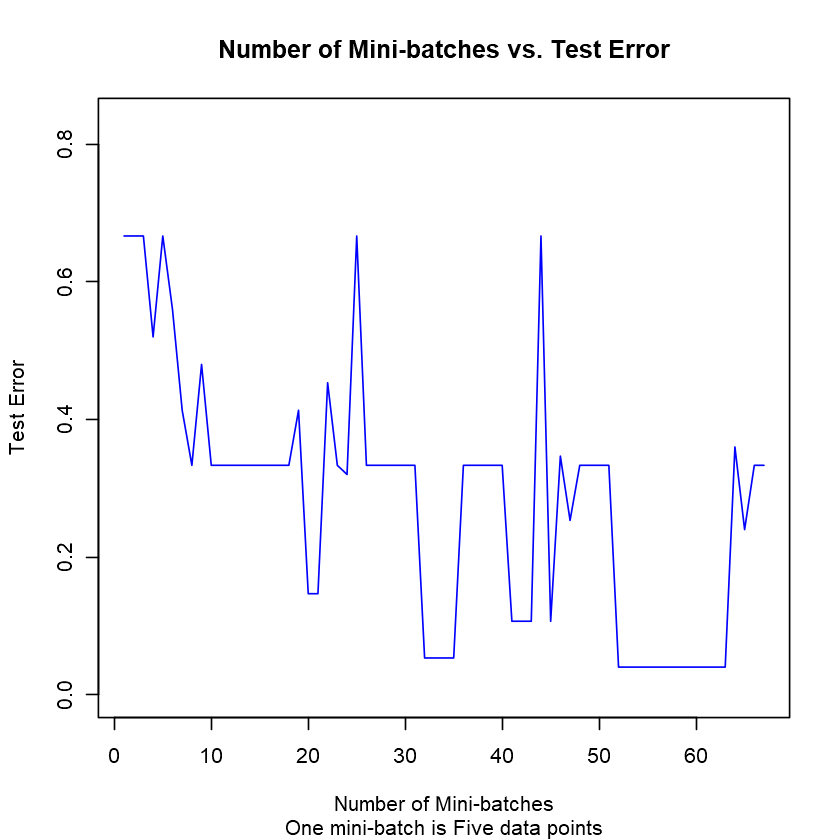

In [33]:
plot(x = errors[ ,'miniBatch'], y =errors[ ,'testError'], ylim = c(0,max(errors[ ,'testError']*1.25)), type = 'l', 
     col = 'blue', main = "Number of Mini-batches vs. Test Error", xlab = "Number of Mini-batches", ylab = "Test Error",
     sub = "One mini-batch is Five data points")